In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import math
import time
from IPython.display import display, clear_output
import PIL.Image
import io

In [ ]:
!pip install mediapipe twilio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 36.6 MB/s eta 0:00:00


In [ ]:
from twilio.rest import Client

In [ ]:
TWILIO_SID = "AC290532181270f50d35e774672821af30"
TWILIO_AUTH_TOKEN = "d6a82ef22603d25c11979db3214d570c"
TWILIO_PHONE_NUMBER = "+18597656531"
YOUR_PHONE_NUMBER = "+919600030652"

In [ ]:
client = Client(TWILIO_SID, TWILIO_AUTH_TOKEN)

In [ ]:
# =====================
# 3. Initialize MediaPipe
# =====================
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

# =====================
# 4. Fall Detection Logic
# =====================
def calculate_torso_angle(landmarks, image_width, image_height):
    try:
        left_shoulder = landmarks.landmark[mp_holistic.PoseLandmark.LEFT_SHOULDER]
        right_shoulder = landmarks.landmark[mp_holistic.PoseLandmark.RIGHT_SHOULDER]
        left_hip = landmarks.landmark[mp_holistic.PoseLandmark.LEFT_HIP]
        right_hip = landmarks.landmark[mp_holistic.PoseLandmark.RIGHT_HIP]

        shoulder_mid = ((left_shoulder.x + right_shoulder.x) / 2 * image_width,
                        (left_shoulder.y + right_shoulder.y) / 2 * image_height)
        hip_mid = ((left_hip.x + right_hip.x) / 2 * image_width,
                   (left_hip.y + right_hip.y) / 2 * image_height)

        delta_x = hip_mid[0] - shoulder_mid[0]
        delta_y = hip_mid[1] - shoulder_mid[1]

        angle = math.degrees(math.atan2(abs(delta_x), delta_y)) if delta_y != 0 else 90
        return angle
    except:
        return 0

# =====================
# 5. Run Fall Detection on Uploaded Video
# =====================
def detect_fall_in_video(video_path):
    holistic = mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5)
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    fall_detected = False

    while cap.isOpened():
        success, frame = cap.read()
        if not success:
            break

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = holistic.process(frame_rgb)

        if results.pose_landmarks:
            mp_drawing.draw_landmarks(
                frame, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)

            angle = calculate_torso_angle(results.pose_landmarks, frame.shape[1], frame.shape[0])

            if angle > 80:  # Arbitrary fall angle threshold
                cv2.putText(frame, f"Fall Detected (Angle: {int(angle)} deg)",
                            (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 2)
                fall_detected = True
            else:
                cv2.putText(frame, f"Angle: {int(angle)} deg", (10, 50),
                            cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 2)

        # Display frame in Colab
        is_success, im_buf_arr = cv2.imencode(".jpg", frame)
        if is_success:
            clear_output(wait=True)
            display(PIL.Image.open(io.BytesIO(im_buf_arr)))

        time.sleep(0.05)
        frame_count += 1

    cap.release()
    holistic.close()
    print("Done! Total frames:", frame_count)
    if fall_detected:
        print("Fall was detected in the video.")
        message = client.messages.create(
        body="Fall detected! Please check on the person.",
        from_=TWILIO_PHONE_NUMBER,  # Twilio number
        to=YOUR_PHONE_NUMBER    # Your phone number
        )
        print("SMS sent:", message.sid)
    else:
        print("No fall detected.")

# =====================



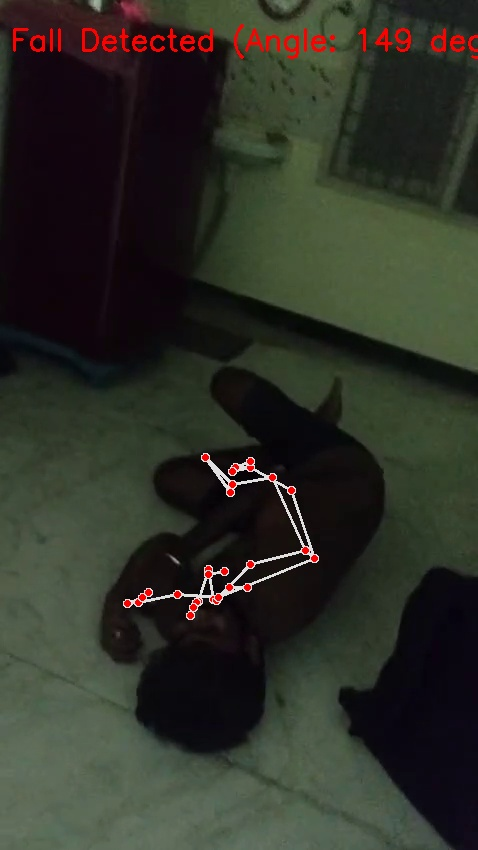

Done! Total frames: 60
Fall was detected in the video.
SMS sent: SMba262d06e99d2f213852ba5c45a221f0


In [ ]:
# =====================
# 6. Upload a Video (Only Upload)
# =====================
from google.colab import files
uploaded = files.upload()

video_file = list(uploaded.keys())[0]
detect_fall_in_video(video_file)

